# 1. 소개

100,000 개가 넘는 영어 위키피디아의 토론 데이터로 주석은 
toxic  

severe_toxic  

obscene  

threat  

insult  

identity_hate과 같이 되어 있다.


자세한 내용은 위키(https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) 참고  

관련 논문은 (https://arxiv.org/abs/1610.08914) 참고

EDA참고 커널: https://www.kaggle.com/clinma/eda-toxic-comment-classification-challenge


Keras 참고자료 : https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings/data

데이터는 대회 공식 홈페이지나 다음 링크에서 다운로드https://drive.google.com/drive/u/0/folders/12xIOu6AjulYlF0TFkkgbU_qE5iqReA8a



# Introduction

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

from wordcloud import WordCloud

from collections import Counter
import re
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')


sns.set(style="white", context="talk")

In [4]:
DATA_PATH = "/Users/song-yeongsug/workspace/Kaggle_NLP_Song/toxic_comment_EDA_KERAS"

In [5]:
#importing the dataset
df_train=pd.read_csv("data/train.csv")


In [6]:
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


# Adding 'none' columns if there is no '1' in COLUMNS
df_train['none'] = (df_train[COLUMNS].max(axis=1) == 0).astype(int)
COLUMNS.append('none')
CATEGORIES = COLUMNS.copy()

print(df_train.shape)
print(df_train.columns.values)

(159571, 9)
['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate' 'none']


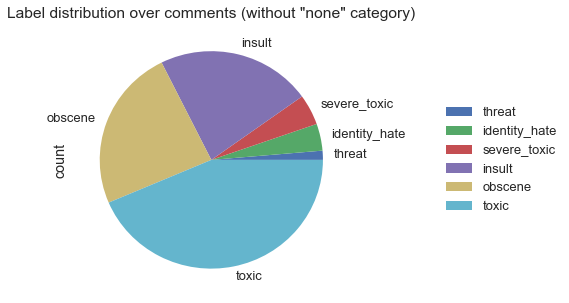

In [7]:
df_distribution = df_train[COLUMNS].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.drop('none').plot.pie(y='count',
                                      title='Label distribution over comments (without "none" category)',
                                      figsize=(5, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [8]:
df_distribution.sort_values('count', ascending=False)

,count
none,143346
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


주요 레이블

toxic 

obscene 

insult

In [9]:
df_comb = df_train.groupby(COLUMNS)\
                    .size()\
                    .sort_values(ascending=False)\
                    .reset_index()\
                    .rename(columns={0: 'count'})
df_comb.head(n=10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,count
0,0,0,0,0,0,0,1,143346
1,1,0,0,0,0,0,0,5666
2,1,0,1,0,1,0,0,3800
3,1,0,1,0,0,0,0,1758
4,1,0,0,0,1,0,0,1215
5,1,1,1,0,1,0,0,989
6,1,0,1,0,1,1,0,618
7,0,0,1,0,0,0,0,317
8,0,0,0,0,1,0,0,301
9,1,1,1,0,1,1,0,265


'none'이 86061 개로 가장 많다.  
 
최초의 '실제'라벨 인 '악평'은 1 단계에서 6 단계까지 모든 조합으로 제공된다.  

이 6 개의 행에서 'obscene'은 4 번 나타난다.  

각 조합에 대한 댓글은 기하 급수적으로 감소하고 있다.

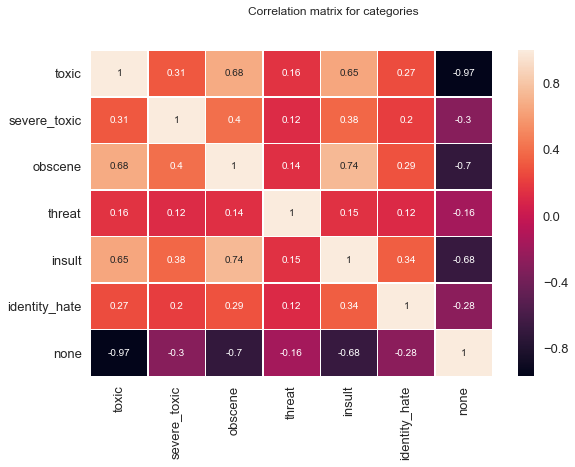

In [10]:
f, ax = plt.subplots(figsize=(9, 6))
f.suptitle('Correlation matrix for categories')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)

위의 매트리스를 통해 알 수 있는 것은   

1. 'toxic' is clearly correlated with 'obscene' and 'insult' (0.68 and 0.65)  

2. 'toxic' and 'severe_toxic' are only got a 0.31 correlation factor    

3. 'insult' and 'obscene' have a correlation factor of 0.74


따라서 몇 가지 조합은 좀 더 살펴 보아야 함


1. 'toxic' <-> 'severe_toxic'. The semantic of these two categories seems to show some kind of graduation between them  

2. 'toxic' <-> 'insult' and 'toxic' <-> 'obscene'  

3. 'insult' <-> 'obscene'

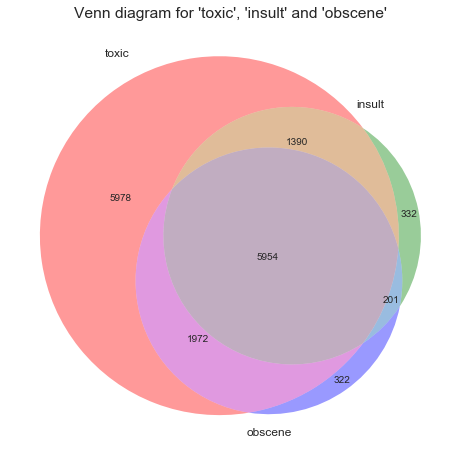

In [11]:
t = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 0)].shape[0]
i = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]

t_i = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
t_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]
i_o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]

t_i_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

1.  'insult' 와 'obscene' 'toxic'으로 레이블 되어 있지 않은 경우는 매우 적다.
 
 
 2. 3,610개의 코멘트가 3개의 범주에 겹쳐서 레이블 되어 있다. 

'toxic' 과 'severe_toxic'만 벤다이어그램으로 좀 더 살펴 보자.

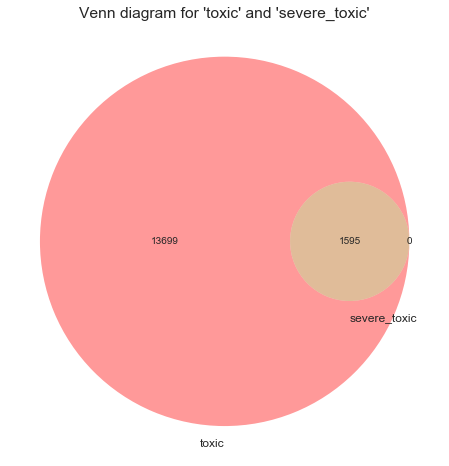

In [12]:
t = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 0)].shape[0]
s = df_train[(df_train['toxic'] == 0) & (df_train['severe_toxic'] == 1)].shape[0]

t_s = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'severe_toxic'")
venn2(subsets = (t, s, t_s), 
      set_labels=('toxic', 'severe_toxic'))
plt.show()


1. 'severe_toxic'카테고리는 'toxic에 완전히 포함되어 있고 두 카테고리 이름 역시 의미론적 연관되어 있다.    

2. 0.31 correlation factor은 'severe_toxic'이 'toxic'의 작은 비율 (11.67 %)을 차지한다는 사실을 설명한다.


1. 총 길이는 글 쓴이에 (좋은 방법이나 나쁜 것 중 하나로)어떤 함의를 나타낼 수 있다.  

2. 총 carriage 리턴 수는 주석에 일종의 구조를 나타낼 수 있다.  

In [13]:
df_train['total_length'] = df_train['comment_text'].str.len()
df_train['new_line'] = df_train['comment_text'].str.count('\n'* 1)
df_train['new_small_space'] = df_train['comment_text'].str.count('\n'* 2)
df_train['new_medium_space'] = df_train['comment_text'].str.count('\n'* 3)
df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)

df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)
df_train['uppercase_words'] = df_train['comment_text'].apply(lambda l: sum(map(str.isupper, list(l))))
df_train['question_mark'] = df_train['comment_text'].str.count('\?')
df_train['exclamation_mark'] = df_train['comment_text'].str.count('!')

FEATURES = ['total_length', 
            'new_line', 
            'new_small_space', 
            'new_medium_space', 
            'new_big_space', 
            'uppercase_words',
            'question_mark',
            'exclamation_mark']
COLUMNS += FEATURES

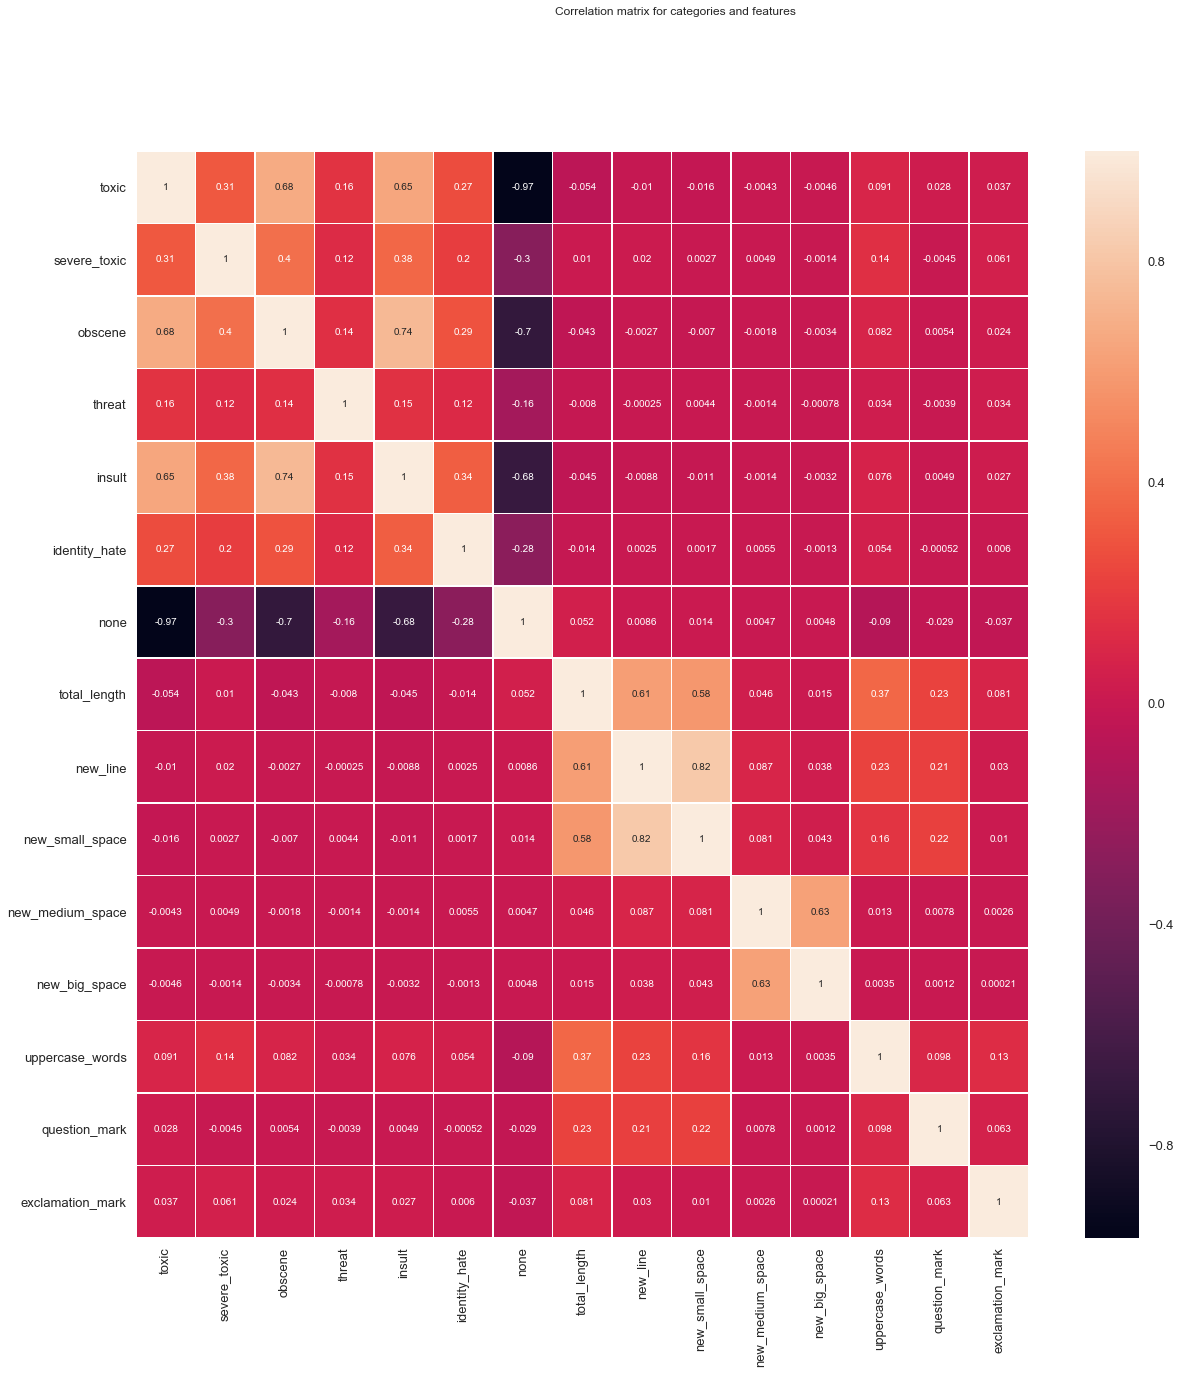

In [14]:
f, ax = plt.subplots(figsize=(20, 20))
f.suptitle('Correlation matrix for categories and features')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)

참고 : small, medium, big space 피처 중 'big_space'는 medium 및 small space를 포함하고 있다. (medium_space의 경우도 동일)  


1. 추가 된 특징을 갖는 새로운 상관 행렬은 강한 상관 관계를 나타내지 않는다.  

2. 주목할 가치가 있는 것은 'uppercase_words'('yelling'같은 것이)가 약간 더 관련이 있다는 것이다.
  
3. 'uppercase_words'는 0.13까지 'exclamation_mark'와 상관 관계가 있다. (글 작성자들이 yelling'에 가능한 한 !'를 많이 붙이는 것과 ㄱ것이다.)


# Word analysis

In [15]:
word_counter = {}


def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])

for categ in CATEGORIES:
    d = Counter()
    df_train[df_train[categ] == 1]['comment_text'].apply(lambda t: d.update(clean_text(t).split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

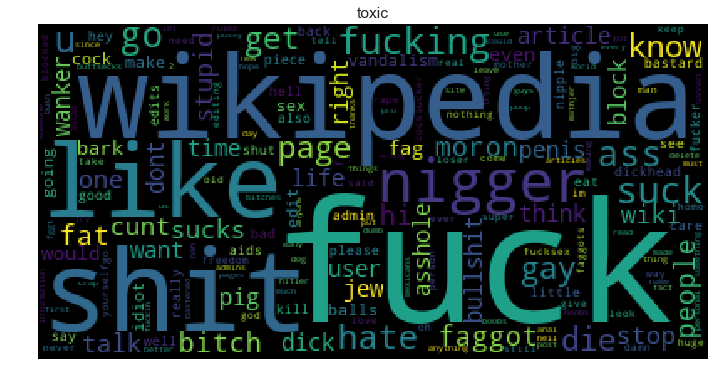

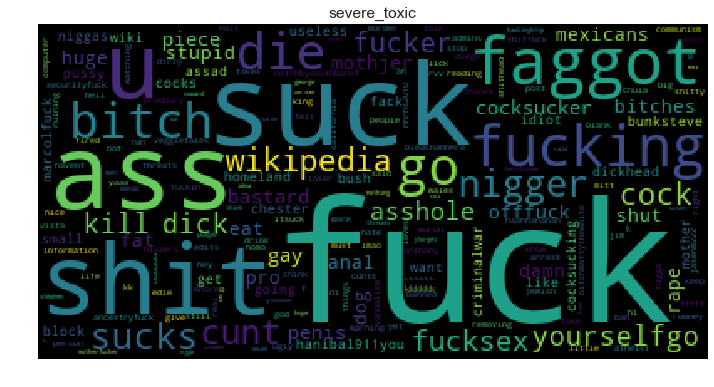

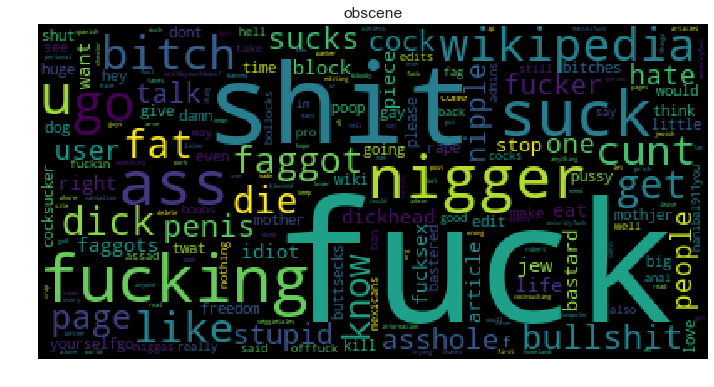

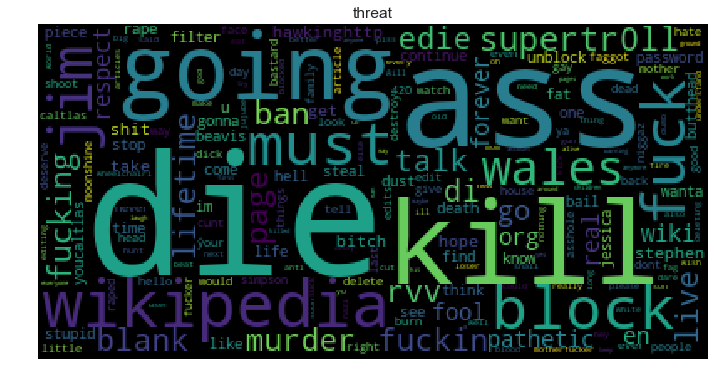

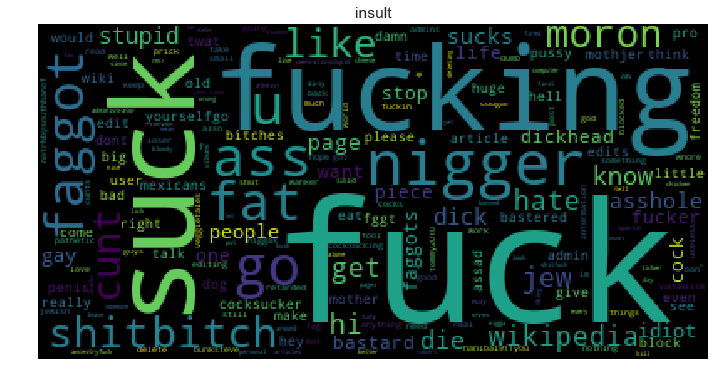

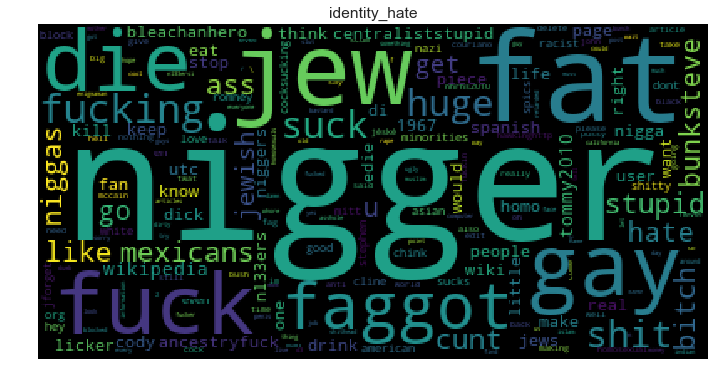

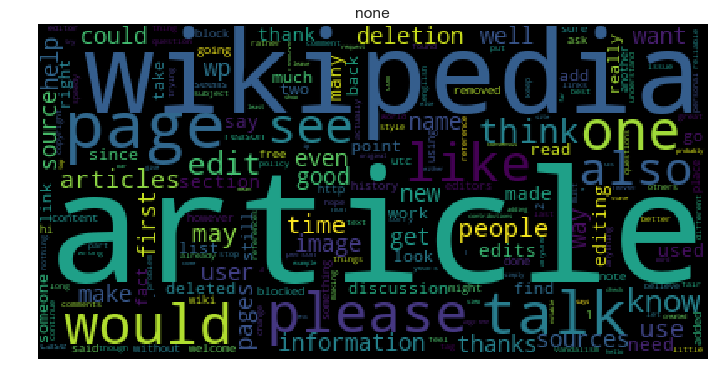

In [16]:
for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(12, 8))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

# Keras CNN with Fasttext Embeddings

윈도우에 Keras설치 및 데이터 과적합 등에 관한 내용은 이태영님 블로그 참고. 


https://tykimos.github.io/2017/03/25/Dataset_and_Fit_Talk/

In [17]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(0)
     
DATA_PATH = '/Users/song-yeongsug/workspace/Kaggle_NLP_Song/toxic_comment_EDA_KERAS/data'
EMBEDDING_DIR = '/Users/song-yeongsug/workspace/Kaggle_NLP_Song/toxic_comment_EDA_KERAS'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

from subprocess import check_output
print(check_output(["ls", "/Users/song-yeongsug/workspace/Kaggle_NLP_Song/toxic_comment_EDA_KERAS"]).decode("utf8"))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


data
toxic_comment_EDA_KERAS.ipynb



In [19]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/Users/song-yeongsug/workspace/Kaggle_NLP_Song/toxic_comment_EDA_KERAS/data/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

758it [00:00, 7576.05it/s]

loading word embeddings...


111052it [00:11, 9518.83it/s]

found 111052 word vectors


num train:  159571
num test:  153164


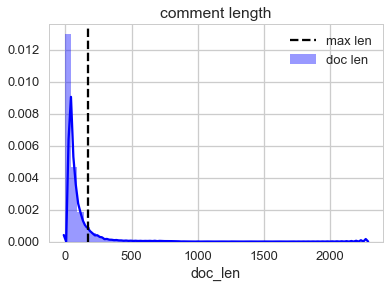

In [21]:
#load data
train_df = pd.read_csv('/Users/song-yeongsug/workspace/Kaggle_NLP_Song/toxic_comment_EDA_KERAS/data' + '/train.csv', sep=',', header=0)
test_df = pd.read_csv('/Users/song-yeongsug/workspace/Kaggle_NLP_Song/toxic_comment_EDA_KERAS/data' + '/test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train_df[label_names].values

#visualize word distribution
train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [22]:
raw_docs_train = train_df['comment_text'].tolist()
raw_docs_test = test_df['comment_text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  4%|▍         | 6173/159571 [00:00<00:04, 30854.99it/s]

pre-processing train data...


100%|██████████| 153164/153164 [00:04<00:00, 35827.34it/s]


tokenizing input data...
dictionary size:  348520


In [23]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [24]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 47196


In [25]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['bunchofgrapes' 'hapy' 'kwilu' 'weant' 'sthenelaos' 'everyon' 'mcsim'
 'kodachrome' 'latibeaudiere' 'thấp']


In [26]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 168, 300)          30000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 168, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 84, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080

학습이 과적합되는 것을 막기 위해 학습을 조기 종료한다.

In [27]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [29]:
#model training

hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Train on 143613 samples, validate on 15958 samples
Epoch 1/8
 - 301s - loss: 0.0982 - acc: 0.9696 - val_loss: 0.0669 - val_acc: 0.9780
Epoch 2/8
 - 303s - loss: 0.0653 - acc: 0.9788 - val_loss: 0.0641 - val_acc: 0.9788
Epoch 3/8
 - 303s - loss: 0.0587 - acc: 0.9804 - val_loss: 0.0590 - val_acc: 0.9798
Epoch 4/8
 - 327s - loss: 0.0531 - acc: 0.9816 - val_loss: 0.0579 - val_acc: 0.9802
Epoch 5/8
 - 335s - loss: 0.0488 - acc: 0.9828 - val_loss: 0.0574 - val_acc: 0.9800
Epoch 00005: early stopping


In [30]:
y_test = model.predict(word_seq_test)

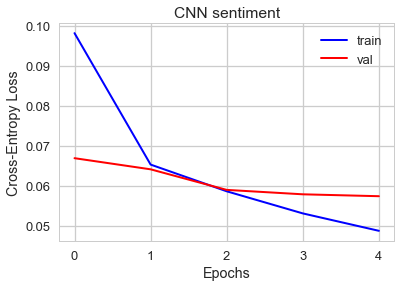

In [31]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

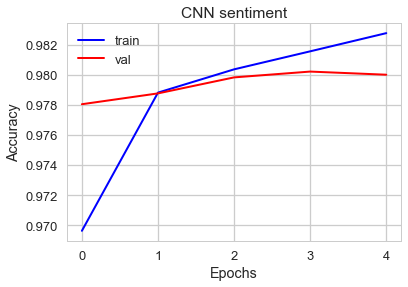

In [32]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

References:  

[1] P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, "Enriching Word Vectors with Subword Information", arXiv, 2016
[2] FastText Embeddings: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md
[3] F. Chollet, "Deep Learning with Python", Manning Publications, 2017